## Background

There is a lack of public available datasets on financial services and specially in the emerging mobile money transactions domain. Financial datasets are important to many researchers in the domain of fraud detection. Part of the problem is the intrinsically private nature of financial transactions, that leads to no publicly available datasets for model exploration and building.

A synthetic dataset were generated using the simulator called PaySim. PaySim uses aggregated data from the private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behaviour to later evaluate the performance of fraud detection methods.


## Goal
The goal of this analysis is to develop a generalized model to deal with **big and imblance data** prediction that suitable to real-world applications. The big data part was sloved by using the pysark.


### Data

The data of this project can be downloaded from [here](https://www.kaggle.com/ntnu-testimon/paysim1).

The explanation columns of input data:

**One row**: 1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

**Column names with explanition**: 

* step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

* type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

* amount - amount of the transaction in local currency.

* nameOrig - customer who started the transaction

* oldbalanceOrg - initial balance before the transaction

* newbalanceOrig - new balance after the transaction

* nameDest - customer who is the recipient of the transaction

* oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

* newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

* isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

* isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200,000 in a single transaction.


The structure of the notebook is borrowed from [here](https://www.kaggle.com/arjunjoshua/predicting-fraud-in-financial-payment-services) where they used pandas and sklearn to conduct the fraud detection. 

## Setup pyspark

If this is your first time to set up pyspark, please follow the [intructions](https://medium.com/@naomi.fridman/install-pyspark-to-run-on-jupyter-notebook-on-windows-4ec2009de21f) to set it up properly.


In [1]:
import findspark
findspark.init()
findspark.find()

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import pyspark.sql.functions as F

## 1 Import data

In [3]:
sc = SparkContext(appName="finicial fraud detection")
sqlc = SQLContext(sc)

In [4]:
## data
data_file = './data/PS_20174392719_1491204439457_log.csv'

In [5]:
data = sqlc.read.csv(data_file,header = True)

## 2 Data exploration

In [6]:
data.count()

6362620

In [7]:
data.dtypes

[('step', 'string'),
 ('type', 'string'),
 ('amount', 'string'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'string'),
 ('newbalanceOrig', 'string'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'string'),
 ('newbalanceDest', 'string'),
 ('isFraud', 'string'),
 ('isFlaggedFraud', 'string')]

In [8]:
data.limit(3).toPandas()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0


In [9]:
data.groupBy('isFraud').count().show()

+-------+-------+
|isFraud|  count|
+-------+-------+
|      0|6354407|
|      1|   8213|
+-------+-------+



**Tips:** We can see this is imblance data and we should use stratified split method in the following operation

In [10]:
### check if there is missing values in the data
from pyspark.sql.functions import col,sum
data.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in data.columns)).show()

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|            0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



### 2.1 Understand the data which belongs to fraudulent

In [11]:
subd = data.filter(data['isFraud'] == 1).groupby('type').count().show()

+--------+-----+
|    type|count|
+--------+-----+
|TRANSFER| 4097|
|CASH_OUT| 4116|
+--------+-----+



**Observation**: it looks only type is TRANSFER or CASH_OUT will be fraud.

In [12]:
data.groupby('isFlaggedFraud').count().show()

+--------------+-------+
|isFlaggedFraud|  count|
+--------------+-------+
|             0|6362604|
|             1|     16|
+--------------+-------+



### 2.2 check if this is consistent with the decription of the column that more than 200,200 will be conisdered as illegeal

In [13]:
data.filter(data['isFlaggedFraud'] == 1).orderBy('amount').show()

+----+--------+----------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|    amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+----------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
| 425|TRANSFER|     1.0E7| C689608084|1.958504037E7| 1.958504037E7|C1392803603|           0.0|           0.0|      1|             1|
| 730|TRANSFER|     1.0E7|C2140038573|1.731625505E7| 1.731625505E7|C1395467927|           0.0|           0.0|      1|             1|
| 646|TRANSFER|     1.0E7|  C19004745|1.039904508E7| 1.039904508E7|C1806199534|           0.0|           0.0|      1|             1|
| 250|TRANSFER|1343002.08|C1100582606|   1343002.08|    1343002.08|C1147517658|           0.0|           0.0|      1|             1|
| 617|TRANSFER|2542664.27| C786455622|   2542664.27|    2542664.27| C

### Check the min and max of the values when it's flagged as fraud

In [14]:
max1 = data.filter(data['isFlaggedFraud'] == 1).agg({"amount": "max"}).collect()[0]
min1 = data.filter(data['isFlaggedFraud'] == 1).agg({"amount": "min"}).collect()[0]

In [15]:
max1 = data.filter(data['isFlaggedFraud'] == 1).agg({"amount": "mean"}).collect()[0]

In [16]:
data.groupBy(['isFlaggedFraud']).agg({'amount':'avg','isFlaggedFraud':'count'}).show()

+--------------+------------------+---------------------+
|isFlaggedFraud|       avg(amount)|count(isFlaggedFraud)|
+--------------+------------------+---------------------+
|             0|179850.13041768773|              6362604|
|             1|    4861597.730625|                   16|
+--------------+------------------+---------------------+



### Multiple columns and multiple functions

In [17]:
from pyspark.sql.functions import mean, sum, max, col,count
groupBy = ["isFlaggedFraud"]
aggregate = ["amount"] 
funs = [mean, sum, max,count]

exprs = [f(col(c)) for f in funs for c in aggregate]

In [18]:
re1 = data.groupby(*groupBy).agg(*exprs).collect()

In [19]:
re1

[Row(isFlaggedFraud='0', avg(amount)=179850.13041768366, sum(amount)=1144315159196.0757, max(amount)='99999.81', count(amount)=6362604),
 Row(isFlaggedFraud='1', avg(amount)=4861597.730625, sum(amount)=77785563.69, max(amount)='9585040.37', count(amount)=16)]

In [20]:
max0 = data.filter(data['isFlaggedFraud'] == 0).agg({"amount": "max"}).collect()[0]
min0 = data.filter(data['isFlaggedFraud'] == 0).agg({"amount": "min"}).collect()[0]

In [21]:
max1[0],min1[0],max0[0],min0[0]

(4861597.730625, '1.0E7', '99999.81', '0.0')

**Observations**: Once is flagged as fraud, the destination's account are always zero before and after transcation. It 
    made sense as the transcation will be halted when it's flagged as fraud.

In [22]:
data.filter( (data['isFlaggedFraud'] == 0) & (data['oldbalanceDest'] ==0) & (data['newbalanceDest'] ==0)).show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 7817.71|  C90045638|      53860.0|      46042.29| M573487274|      

In [23]:
### whether the account names is duplicated or not when it is flagged as fraud
data.filter(data['isFlaggedFraud'] == 1).groupBy('nameOrig').count().show()

+-----------+-----+
|   nameOrig|count|
+-----------+-----+
|C2140038573|    1|
|C1684585475|    1|
| C452586515|    1|
| C917414431|    1|
| C724693370|    1|
| C728984460|    1|
| C992223106|    1|
|C1869569059|    1|
|  C19004745|    1|
| C908544136|    1|
|C1035541766|    1|
|C1100582606|    1|
| C689608084|    1|
| C193696150|    1|
| C786455622|    1|
|C1892216157|    1|
+-----------+-----+



In [24]:
data.filter(data['isFlaggedFraud'] == 1).groupBy('nameDest').count().show()

+-----------+-----+
|   nameDest|count|
+-----------+-----+
|C1806199534|    1|
|C1861208726|    1|
|C1147517658|    1|
|C1395467927|    1|
| C661958277|    1|
|C1392803603|    1|
| C484597480|    1|
|C1909486199|    1|
| C639921569|    1|
|C1082139865|    1|
|C1100697970|    1|
|C1770418982|    1|
|C1308068787|    1|
|C1109166882|    1|
| C891140444|    1|
|C1366804249|    1|
+-----------+-----+



### 2.3. Are expected merchant accounts accordingly labelled?
It was stated <a href='http://www2.bth.se/com/edl.nsf/pages/phd-dissertation'>[5]</a> that CASH_IN involves being paid by
a merchant (whose name is prefixed by 'M'). However, as shown below, the present data does not have
merchants making CASH_IN transactions to customers.

In [25]:
subd1 = data.filter( (data['type'] == 'CASH_IN') & \
                (data['nameOrig'].like('%M%')) ).show(4)

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



In [26]:
subd1 = data.filter( (data['type'] == 'CASH_OUT') & \
                (data['nameOrig'].like('%M%')) ).show(4)

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



In [27]:
data.filter(data['nameDest'].like('%M%')).groupBy('type').count().show()

+-------+-------+
|   type|  count|
+-------+-------+
|PAYMENT|2151495|
+-------+-------+



In [28]:
data.filter( (col('nameDest').isin(col('nameOrig'))) & (data['isFraud'] == 1)).show(5)

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



### Names of Fraud and not Fraud

In [29]:
df1 = data.filter(data['isFraud'] == 1) ## fraud
df0 = data.filter(data['isFraud'] == 0) ## not fraud

In [30]:
##Get the unique names if the data is fraud
unique_org_names1 = [i.nameOrig for i in df1.select('nameOrig').distinct().collect()]
unique_org_names0 = [i.nameOrig for i in df0.select('nameOrig').distinct().collect()]

In [31]:
# unique_org_names1 = data.select('nameOrig').distinct().rdd.map(lambda r: r[0]).collect()
## work the same as the comprehension

In [32]:
data.filter(col('nameDest').isin(unique_org_names1)).show(5)

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



Could destination accounts for fraudulent TRANSFERs originate CASHOUTs that
are not detected and are labeled as genuine? It turns out there are  3 such
accounts.

In [33]:
##take a long time to run, we can used join and broadcase to make it faster
## https://stackoverflow.com/questions/53737952/slow-filtering-of-pyspark-dataframes
#subd = df1.filter(df1['nameDest'].isin(unique_org_names0))

### Faster way to filter when the number of filter is big
It looks didn't work when we join them together

In [34]:
# list_filter_df = sqlc.createDataFrame([[x] for x in unique_org_names0], df1.columns[6:7])

In [35]:
# subd = df1.join(F.broadcast(list_filter_df),df1.columns[6:7])

## 3 Data cleaning

In [36]:
x0 = data.filter(data['type'].isin(['CASH_OUT','TRANSFER']))

In [37]:
data.select(['type']).distinct().show()

+--------+
|    type|
+--------+
|TRANSFER|
| CASH_IN|
|CASH_OUT|
| PAYMENT|
|   DEBIT|
+--------+



##### Destination account - replace zero with -1

In [38]:
### chang 0 to more sensible values for some cases
from pyspark.sql.functions import when
import numpy as np

x0 = x0.withColumn('oldbalanceDest', \
              when((x0['oldbalanceDest'] == 0) & (x0['newbalanceDest'] ==0) & (x0['amount'] !=0), -1).otherwise(x0['oldbalanceDest']))

x0 = x0.withColumn('newbalanceDest', \
              when((x0['oldbalanceDest'] == 0) & (x0['newbalanceDest'] ==0) & (x0['amount'] !=0), -1).otherwise(x0['newbalanceDest']))

In [39]:
##check if the replacement working
##double check the results
x0.agg({"oldbalanceDest": "min"}).collect()[0]

Row(min(oldbalanceDest)='-1')

##### Original account - replace zero with nan

In [40]:
# x0 = x0.withColumn('oldbalanceOrg', \
#               when((x0['oldbalanceOrg'] == 0) & (x0['newbalanceOrig'] ==0) & (x0['amount'] !=0), np.nan).otherwise(x0['oldbalanceOrg']))

# x0 = x0.withColumn('newbalanceOrig', \
#               when((x0['oldbalanceOrg'] == 0) & (x0['newbalanceOrig'] ==0) & (x0['amount'] !=0), np.nan).otherwise(x0['newbalanceOrig']))

#### Convert string to numeric columns

In [41]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
'''x0 is the data frame'''
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(x0) for column in ['type'] ]

pipeline = Pipeline(stages=indexers)
x_r = pipeline.fit(x0).transform(x0)

In [42]:
x_r.limit(5).toPandas()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_index
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,-1,0.0,1,0,1.0
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0,0.0
2,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,0.0
3,1,TRANSFER,215310.3,C1670993182,705.0,0.0,C1100439041,22425.0,0.0,0,0,1.0
4,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1.0


In [43]:
from pyspark.sql.types import IntegerType

In [44]:
xx = x_r.withColumn('type_index',x_r['type_index'].cast(IntegerType()))
xx = xx.withColumn('isFraud',x_r['isFraud'].cast(IntegerType()))

In [45]:
xx = xx.withColumnRenamed('isFraud','label')

In [46]:
xx.limit(5).toPandas()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,label,isFlaggedFraud,type_index
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,-1,0.0,1,0,1
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0,0
2,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,0
3,1,TRANSFER,215310.3,C1670993182,705.0,0.0,C1100439041,22425.0,0.0,0,0,1
4,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1


In [47]:
xf = xx.drop('type')

In [48]:
xf.limit(5).toPandas()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,label,isFlaggedFraud,type_index
0,1,181.0,C1305486145,181.0,0.0,C553264065,-1,0.0,1,0,1
1,1,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0,0
2,1,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,0
3,1,215310.3,C1670993182,705.0,0.0,C1100439041,22425.0,0.0,0,0,1
4,1,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1


## 4 Feature enginering

In [49]:
from pyspark.sql.functions import col

In [50]:
xf = xf.withColumn("errorbalanceOrig", col("newbalanceOrig") + col("amount") - col("oldbalanceOrg"))

In [51]:
xf = xf.withColumn("errorbalanceDest", col("oldbalanceDest") + col("amount") - col("newbalanceDest"))

In [52]:
xf.limit(5).toPandas()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,label,isFlaggedFraud,type_index,errorbalanceOrig,errorbalanceDest
0,1,181.0,C1305486145,181.0,0.0,C553264065,-1,0.0,1,0,1,0.00,180.0
1,1,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0,0,0.00,21363.0
2,1,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,0,213808.94,182703.5
3,1,215310.3,C1670993182,705.0,0.0,C1100439041,22425.0,0.0,0,0,1,214605.30,237735.3
4,1,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,1,300850.89,-2401220.0


## convert data frame types

In [53]:
yv = ['isFraud']
xv = ['step',
      'type_index',
      'amount','oldbalanceOrg','newbalanceOrig',
      'oldbalanceDest','newbalanceDest',"errorbalanceOrig","errorbalanceDest"]


In [54]:
xf.dtypes

[('step', 'string'),
 ('amount', 'string'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'string'),
 ('newbalanceOrig', 'string'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'string'),
 ('newbalanceDest', 'string'),
 ('label', 'int'),
 ('isFlaggedFraud', 'string'),
 ('type_index', 'int'),
 ('errorbalanceOrig', 'double'),
 ('errorbalanceDest', 'double')]

In [55]:
sxv = ['step',
      'amount','oldbalanceOrg','newbalanceOrig',
      'oldbalanceDest','newbalanceDest']
for col_name in sxv:
    xf = xf.withColumn(col_name, col(col_name).cast('float'))

In [56]:
xf.dtypes

[('step', 'float'),
 ('amount', 'float'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'float'),
 ('newbalanceOrig', 'float'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'float'),
 ('newbalanceDest', 'float'),
 ('label', 'int'),
 ('isFlaggedFraud', 'string'),
 ('type_index', 'int'),
 ('errorbalanceOrig', 'double'),
 ('errorbalanceDest', 'double')]

## 5 Train and test data split

In [57]:
from pyspark.sql.functions import lit

### stratified split

Here I used stratified split instead of random split which can overcome the imblance data problem.

In [58]:
fractions = xf.select("label").distinct().withColumn("fraction", lit(0.8)).rdd.collectAsMap()
df_train = xf.sampleBy('label',fractions,seed=17)
df_test = xf.subtract(df_train)

## 6 Model - pipeline

In [59]:
yv = ['label']
xv = ['step','type_index','amount','oldbalanceOrg','newbalanceOrig',
      'oldbalanceDest','newbalanceDest',"errorbalanceOrig","errorbalanceDest"]

### 6.1 convert dataframe to vector

In [60]:
from pyspark.ml.feature import VectorAssembler

vecAssembler = VectorAssembler(inputCols= xv, outputCol="va")

In [61]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator,  TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

### 6.2 Creating PCA (when we have a lot of columns or features)

In [62]:
from pyspark.ml.feature import PCA

pca = PCA(k=5, inputCol="va", outputCol="features")

### 6.3 Create a RF classifer

In [63]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features")

### 6.4 Creating a Multiclass Classification Evaluator

In [64]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator()  

### Creating  a Pipeline

This will be easier when we need to test different scenarios.

In [65]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[vecAssembler, pca, rf])

## 7 Hyperparameter tunning

### Creating Grid Search Configuration 

In [66]:
from pyspark.ml.tuning import CrossValidator, TrainValidationSplit, ParamGridBuilder

paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 4, 6])
             .addGrid(rf.maxBins, [20, 60])
             .addGrid(rf.numTrees, [5, 20])
             .addGrid(rf.impurity, ['gini', 'entropy'])
             .build())

def get_validation(by='cv'):
    if by is 'cv': ##cross validation
        return CrossValidator(
            estimator=pipeline,
            estimatorParamMaps=paramGrid,
            evaluator=evaluator,
            numFolds=10)
    
    elif by is 'tvs': ##train and test split
        return TrainValidationSplit(
            estimator=pipeline,
            estimatorParamMaps=paramGrid,
            evaluator=evaluator,
            # 80% of the data will be used for training, 20% for validation.
            trainRatio=0.8)
    else:
        print('please, pick either cv or tvs')
        return None
    
def evaluate(model, df_train, df_test):
    train_pred = model.transform(df_train)
    train_acc = evaluator.evaluate(train_pred)
    
    test_pred = model.transform(df_test)
    test_acc = evaluator.evaluate(test_pred)
    
    print('train_acc: {}, test_acc: {}'.format(train_acc, test_acc))
    
    return train_pred, test_pred

In [67]:
df_train.dtypes

[('step', 'float'),
 ('amount', 'float'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'float'),
 ('newbalanceOrig', 'float'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'float'),
 ('newbalanceDest', 'float'),
 ('label', 'int'),
 ('isFlaggedFraud', 'string'),
 ('type_index', 'int'),
 ('errorbalanceOrig', 'double'),
 ('errorbalanceDest', 'double')]

In [68]:
val = get_validation('cv')
model_cv = val.fit(df_train)

## Best model

In [69]:

bestModel = model_cv.bestModel
finalPredictions = bestModel.transform(df_train)
evaluator.evaluate(finalPredictions)

0.9982429452987667

### Get the hyper-paramters of the best model

In [70]:
bestModel.stages[-1]._java_obj.getImpurity()

'gini'

In [71]:
bestModel.stages[-1]._java_obj.getMaxDepth()

6

In [72]:
bestModel.stages[-1]._java_obj.getMaxBins()

60

In [73]:
bestModel.stages[-1]._java_obj.getNumTrees()

5

#### it's weired that the paramters are empty when tried the following way

In [74]:
{param[0].name: param[1] for param in bestModel.extractParamMap().items()}

{}

## Evalution of Model - Accuracy

In [75]:
train_pred, test_pred = evaluate(model_cv, df_train, df_test)

train_acc: 0.9982429452987667, test_acc: 0.9983130605061563


## Evalution of Model - Precision - Recall

In [76]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

class Util:
        
    def report_classification(model, df_train, df_test, X_features, y_feature):
        
        classes_train = np.unique(df_train[y_feature].values).tolist()
        classes_test = np.unique(df_test[y_feature].values).tolist()
        
        assert (classes_train == classes_test)
        
        classes = classes_train # The order of class is important!
        
        X_train = df_train[X_features].values.tolist()
        X_test = df_test[X_features].values.tolist()
        
        y_train = df_train[y_feature].values.tolist()
        y_test = df_test[y_feature].values.tolist()
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        report_cm(y_train, y_test, y_train_pred, y_test_pred, classes)
        
    def report_cm(y_train, y_test, y_train_pred, y_test_pred, classes):
        figure, axes = plt.subplots(1, 2, figsize=(10,5))

        cm_test = confusion_matrix(y_test, y_test_pred)
        df_cm_test = pd.DataFrame(cm_test, index = classes, columns = classes)
        ax = sns.heatmap(df_cm_test, annot=True, ax = axes[0], square= True)
        ax.set_title('Test CM')

        cm_train = confusion_matrix(y_train, y_train_pred)
        df_cm_train = pd.DataFrame(cm_train, index = classes, columns = classes)
        ax = sns.heatmap(df_cm_train, annot=True, ax = axes[1], square= True)
        ax.set_title('Train CM')

        print('-' * 20 + 'Testing Performance' + '-' * 20)
        print(classification_report(y_test, y_test_pred, target_names = classes))
        print('acc: ', metrics.accuracy_score(y_test, y_test_pred))

        print('-' * 20 + 'Training Performance' + '-' * 20)
        print(classification_report(y_train, y_train_pred, target_names = classes))
        print('acc: ', metrics.accuracy_score(y_train, y_train_pred))

--------------------Testing Performance--------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553790
           1       0.92      0.54      0.68      1646

    accuracy                           1.00    555436
   macro avg       0.96      0.77      0.84    555436
weighted avg       1.00      1.00      1.00    555436

acc:  0.9985056784219964
--------------------Training Performance--------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2208406
           1       0.91      0.53      0.67      6567

    accuracy                           1.00   2214973
   macro avg       0.96      0.76      0.83   2214973
weighted avg       1.00      1.00      1.00   2214973

acc:  0.9984496425012855


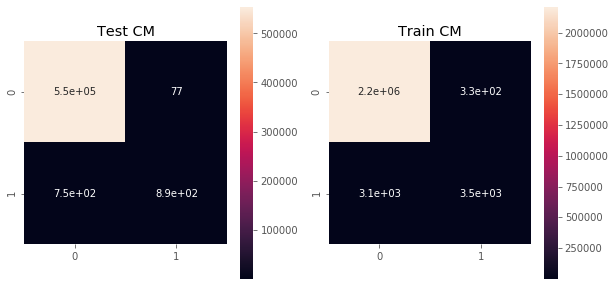

In [77]:
y_train = train_pred.select('label').toPandas().apply(lambda x : x[0], 1).values.tolist()
y_train_pred = train_pred.select('prediction').toPandas().apply(lambda x : x[0], 1).values.tolist()

y_test = test_pred.select('label').toPandas().apply(lambda x : x[0], 1).values.tolist()
y_train_test = test_pred.select('prediction').toPandas().apply(lambda x : x[0], 1).values.tolist()

Util.report_cm(y_train, y_test, y_train_pred, y_train_test, ['0', '1'])

In [78]:
selected = train_pred.select("label", "prediction", "probability")
display(selected.show(10))

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    1|       0.0|[0.97487566571425...|
|    1|       0.0|[0.99873722263147...|
|    0|       0.0|[0.99955494596226...|
|    0|       0.0|[0.99955494596226...|
|    0|       0.0|[0.99955494596226...|
|    0|       0.0|[0.99955494596226...|
|    0|       0.0|[0.99865309423126...|
|    0|       0.0|[0.99873722263147...|
|    0|       0.0|[0.55658088385453...|
|    0|       0.0|[0.99955494596226...|
+-----+----------+--------------------+
only showing top 10 rows



None